In [1]:
pip install --upgrade torch torchvision torchaudio


^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from torchvision import datasets, transforms

DATA_DIR = "og_dataset"

# remove problematic folder
bad_folder = os.path.join(DATA_DIR, "extracted_images")
if os.path.exists(bad_folder):
    print(f"⚠️ Removing {bad_folder} (not a valid class folder)")
    import shutil
    shutil.rmtree(bad_folder)

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_transforms)
print(f"✅ Found {len(full_dataset.classes)} classes: {full_dataset.classes}")


✅ Found 89 classes: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


In [2]:
# 03_models.py
import torch
import torch.nn as nn
from torchvision import models, transforms

def get_model(model_name: str, num_classes: int, pretrained: bool = True):
    """
    Loads a pre-trained model and replaces the final classification layer.
    """
    if model_name == 'resnet18':
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b0':
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'vit_b_16':
        weights = models.ViT_B_16_Weights.DEFAULT if pretrained else None
        model = models.vit_b_16(weights=weights)
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    return model


def get_transforms():
    """
    Returns train and validation transforms with augmentation for training.
    """
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return train_transforms, val_transforms


def save_model(model, model_name: str):
    """
    Saves the model with prefix 'R_'.
    """
    filename = f"R_{model_name}_best.pth"
    torch.save(model.state_dict(), filename)
    print(f"💾 Model saved as {filename}")


if __name__ == '__main__':
    # Quick test
    NUM_CLASSES = 68
    for name in ['resnet18', 'efficientnet_b0', 'vit_b_16']:
        print(f"--- Loading {name} ---")
        model = get_model(name, num_classes=NUM_CLASSES)
        dummy_input = torch.randn(4, 3, 224, 224)
        output = model(dummy_input)
        print(f"Output shape: {output.shape}")
        print("-" * 25)


--- Loading resnet18 ---
Output shape: torch.Size([4, 68])
-------------------------
--- Loading efficientnet_b0 ---
Output shape: torch.Size([4, 68])
-------------------------
--- Loading vit_b_16 ---
Output shape: torch.Size([4, 68])
-------------------------


In [6]:
# 04_train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import json
import os
from tqdm import tqdm

# Import helpers from models.py
from models import get_model, get_transforms, save_model

# ------------------------
# Config
# ------------------------
DATA_DIR = "og_dataset"
MODEL_NAME = "resnet18"   # or "efficientnet_b0" / "vit_b_16"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
VAL_SPLIT = 0.2
CHECKPOINT_DIR = "checkpoints"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------------
# Transforms
# ------------------------
train_transforms, val_transforms = get_transforms()

# ------------------------
# Dataset + Debug Checks
# ------------------------
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

print(f"✅ Classes detected: {full_dataset.classes}")
print(f"✅ Class-to-idx mapping: {full_dataset.class_to_idx}")

targets = [s[1] for s in full_dataset.samples]  # all labels
print(f"✅ Total samples: {len(full_dataset.samples)}")
print(f"✅ Label range: {min(targets)} → {max(targets)}")

NUM_CLASSES = len(full_dataset.classes)
print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

assert max(targets) < NUM_CLASSES, (
    f"ERROR: Found a label {max(targets)} >= NUM_CLASSES {NUM_CLASSES}. "
    "Likely an empty or corrupted folder exists in dataset!"
)

# ------------------------
# Train/Val Split
# ------------------------
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Update validation transforms
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ------------------------
# Model, Loss, Optimizer, Scheduler
# ------------------------
model = get_model(MODEL_NAME, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ✅ Fix: no verbose argument (older PyTorch)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Ensure checkpoint dir
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ------------------------
# Training Function
# ------------------------
def train_model(model_name, num_epochs=NUM_EPOCHS):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_acc = 0.0
    best_epoch_acc = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---------------- Training ----------------
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # ---------------- Validation ----------------
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= val_size
        val_acc = val_corrects.double() / val_size
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Step LR scheduler (on validation loss)
        scheduler.step(val_loss)
        for param_group in optimizer.param_groups:
            print(f"📉 Current LR: {param_group['lr']}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch_acc = epoch + 1
            save_model(model, model_name)

    # Save training history
    history["best_epoch"] = best_epoch_acc
    history["best_val_acc"] = best_val_acc.item()

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history, f)

    print(f"✅ Training complete! Best Val Acc = {best_val_acc:.4f} at epoch {best_epoch_acc}")

# ------------------------
# Run Training
# ------------------------
if __name__ == "__main__":
    train_model(MODEL_NAME, NUM_EPOCHS)


✅ Using device: cuda
✅ Classes detected: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
✅ Class-to-idx mapping: {'!': 0, '(': 1, ')': 2, '+': 3, ',': 4, '-': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16, 'A': 17, 'C': 18, 'Delta': 19, 'G': 20, 'H': 21, 'M': 22, 'N': 23, 'R': 24, 'S': 25, 'T': 26, 'X': 27, '_': 28, '__1': 29, 'alpha': 30, 'ascii_124': 31, 'b': 32, 'beta': 33, 'close

Validation: 100%|██████████| 657/657 [03:20<00:00,  3.27it/s]


Train Loss: 0.4305 Acc: 0.8985
Val   Loss: 0.1732 Acc: 0.9463
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 2/10
------------------------------


Validation: 100%|██████████| 657/657 [01:19<00:00,  8.29it/s]


Train Loss: 0.1437 Acc: 0.9550
Val   Loss: 0.1389 Acc: 0.9537
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 3/10
------------------------------


Validation: 100%|██████████| 657/657 [01:22<00:00,  7.95it/s]


Train Loss: 0.0993 Acc: 0.9684
Val   Loss: 0.1089 Acc: 0.9652
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 4/10
------------------------------


Validation: 100%|██████████| 657/657 [01:23<00:00,  7.85it/s]


Train Loss: 0.0733 Acc: 0.9763
Val   Loss: 0.0951 Acc: 0.9694
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 5/10
------------------------------


Validation: 100%|██████████| 657/657 [01:19<00:00,  8.27it/s]


Train Loss: 0.0578 Acc: 0.9820
Val   Loss: 0.0907 Acc: 0.9737
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 6/10
------------------------------


Validation: 100%|██████████| 657/657 [01:20<00:00,  8.21it/s]


Train Loss: 0.0463 Acc: 0.9850
Val   Loss: 0.0785 Acc: 0.9753
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 7/10
------------------------------


Validation: 100%|██████████| 657/657 [01:18<00:00,  8.35it/s]


Train Loss: 0.0394 Acc: 0.9874
Val   Loss: 0.0808 Acc: 0.9754
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 8/10
------------------------------


Validation: 100%|██████████| 657/657 [01:19<00:00,  8.24it/s]


Train Loss: 0.0338 Acc: 0.9892
Val   Loss: 0.0788 Acc: 0.9775
📉 Current LR: 0.0001
💾 Model saved as R_resnet18_best.pth

Epoch 9/10
------------------------------


Validation: 100%|██████████| 657/657 [01:22<00:00,  7.99it/s]


Train Loss: 0.0270 Acc: 0.9914
Val   Loss: 0.0850 Acc: 0.9767
📉 Current LR: 5e-05

Epoch 10/10
------------------------------


Validation: 100%|██████████| 657/657 [01:17<00:00,  8.50it/s]

Train Loss: 0.0124 Acc: 0.9962
Val   Loss: 0.0710 Acc: 0.9835
📉 Current LR: 5e-05
💾 Model saved as R_resnet18_best.pth
✅ Training complete! Best Val Acc = 0.9835 at epoch 10


Using device: cuda
✅ Classes detected: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
✅ Class-to-idx mapping: {'!': 0, '(': 1, ')': 2, '+': 3, ',': 4, '-': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16, 'A': 17, 'C': 18, 'Delta': 19, 'G': 20, 'H': 21, 'M': 22, 'N': 23, 'R': 24, 'S': 25, 'T': 26, 'X': 27, '_': 28, '__1': 29, 'alpha': 30, 'ascii_124': 31, 'b': 32, 'beta': 33, 'close_b

Evaluating: 100%|██████████| 657/657 [03:53<00:00,  2.82it/s]


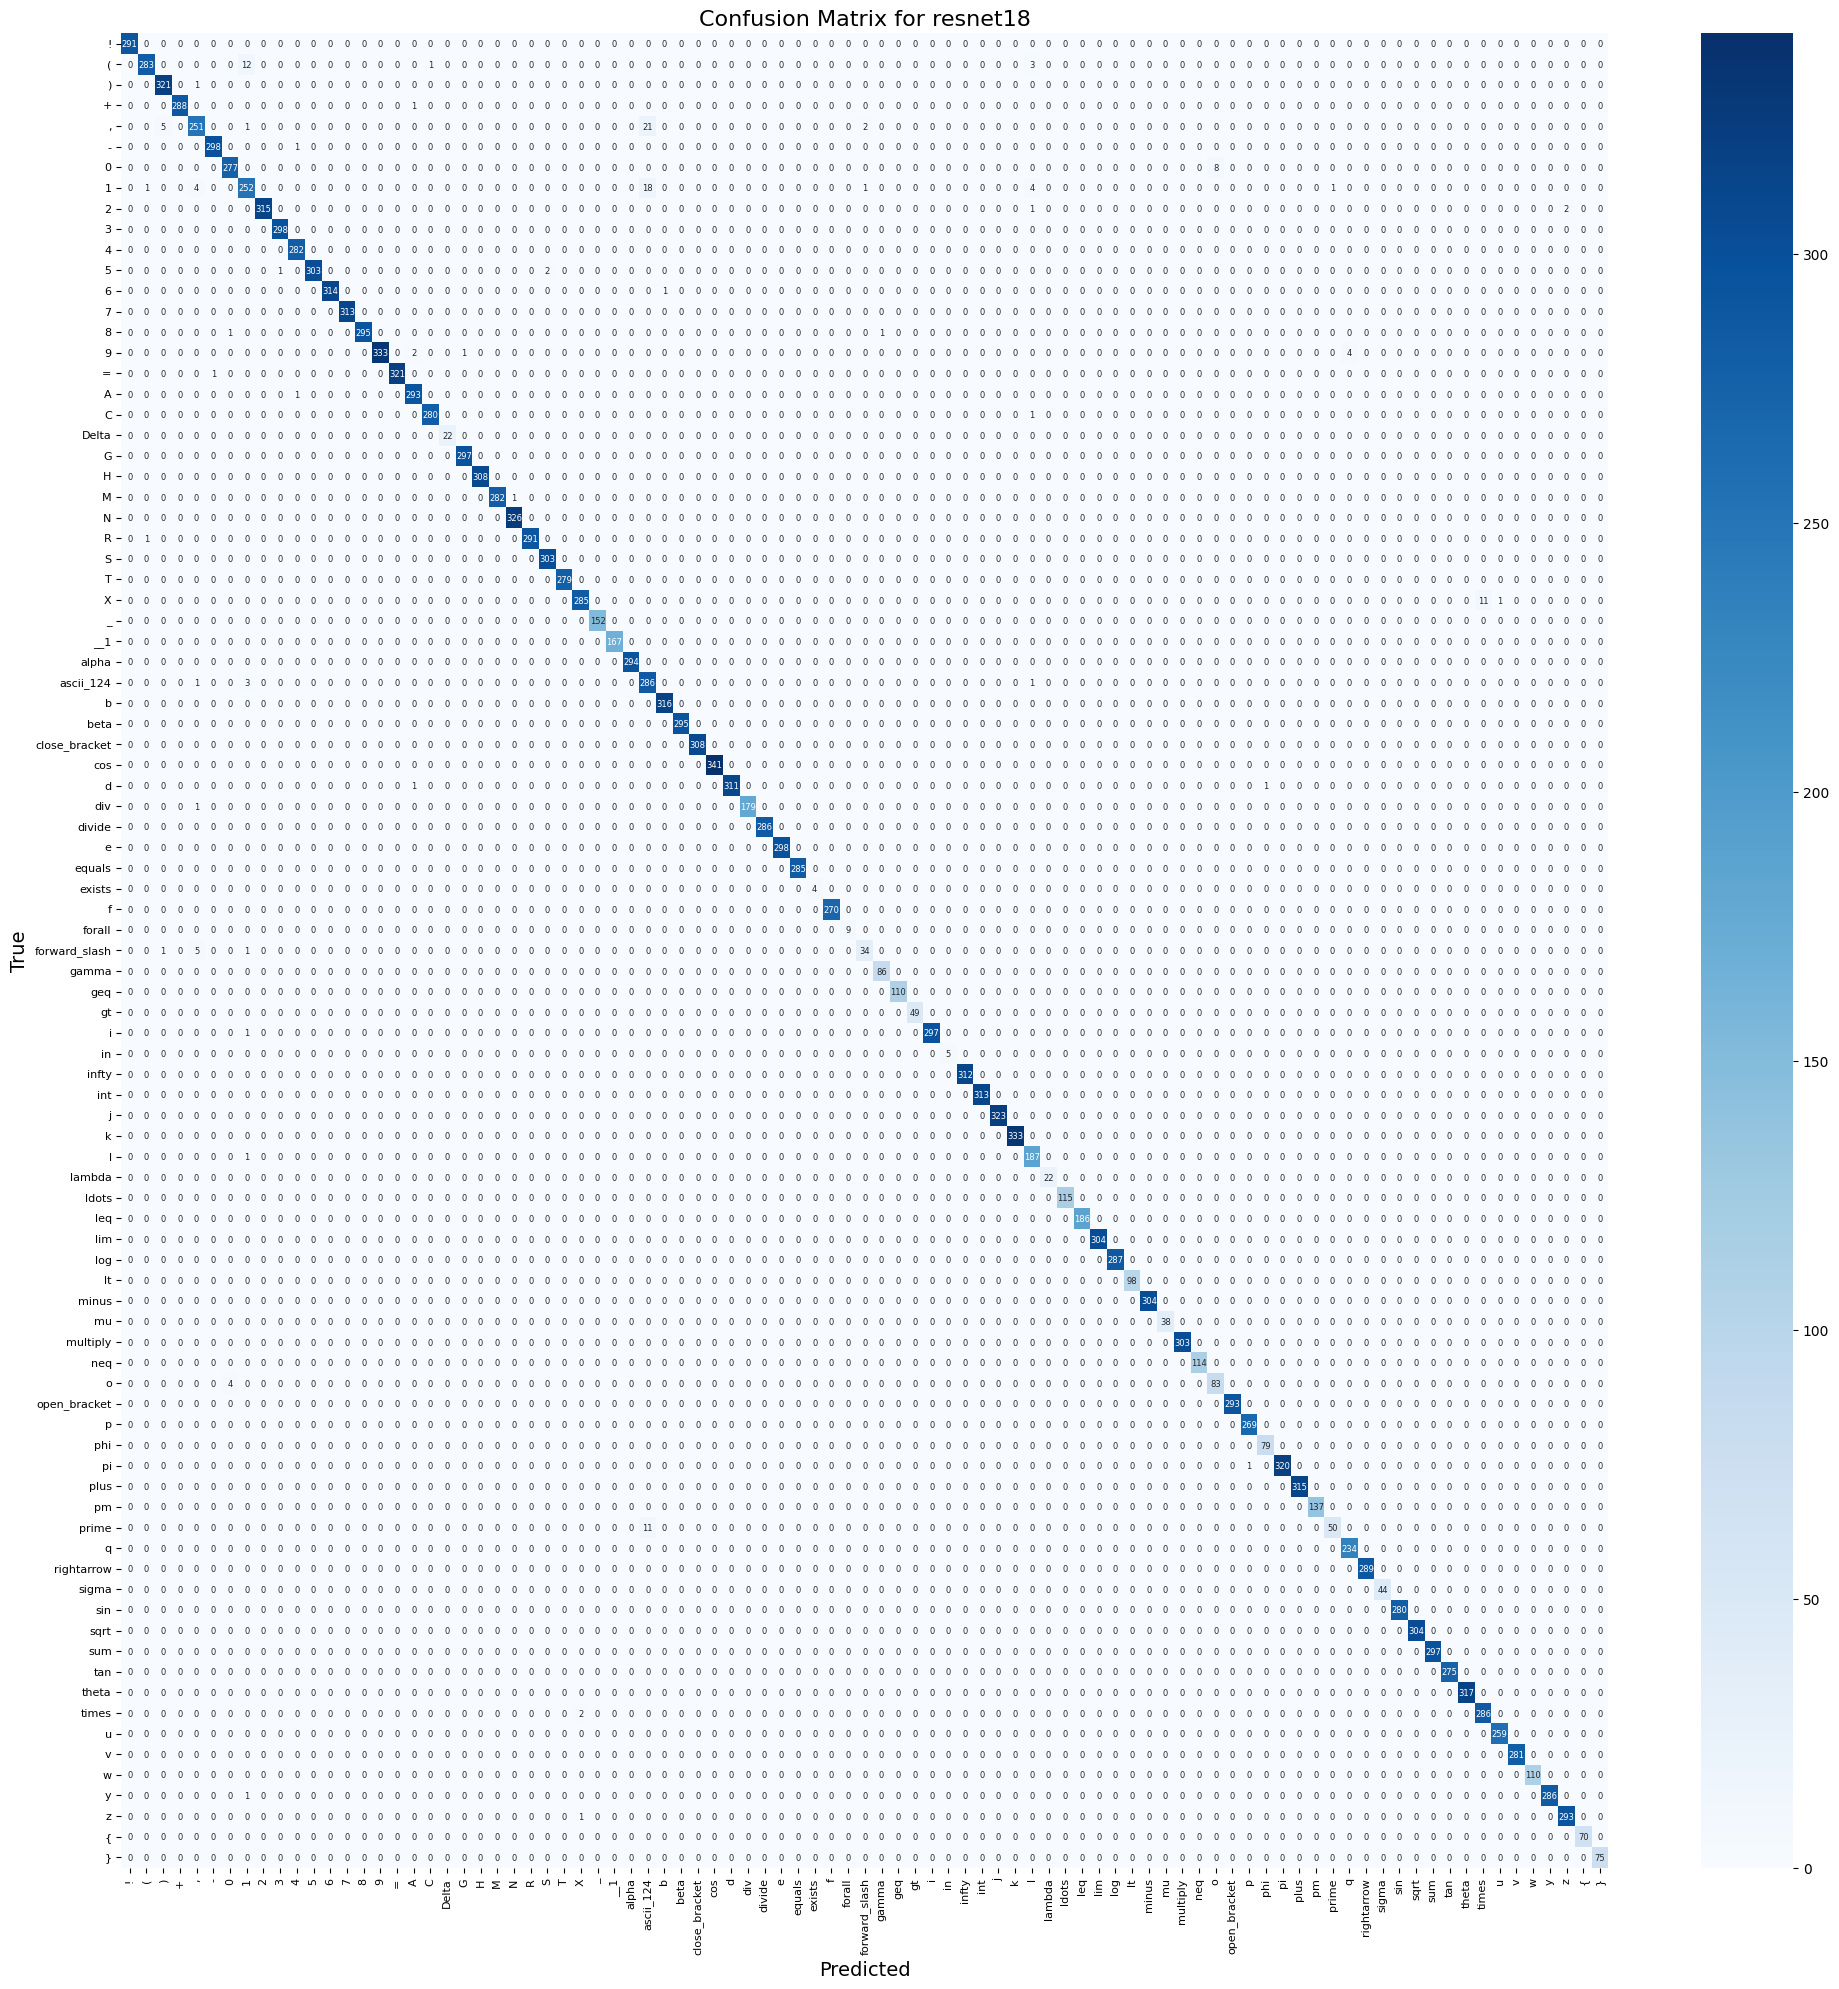

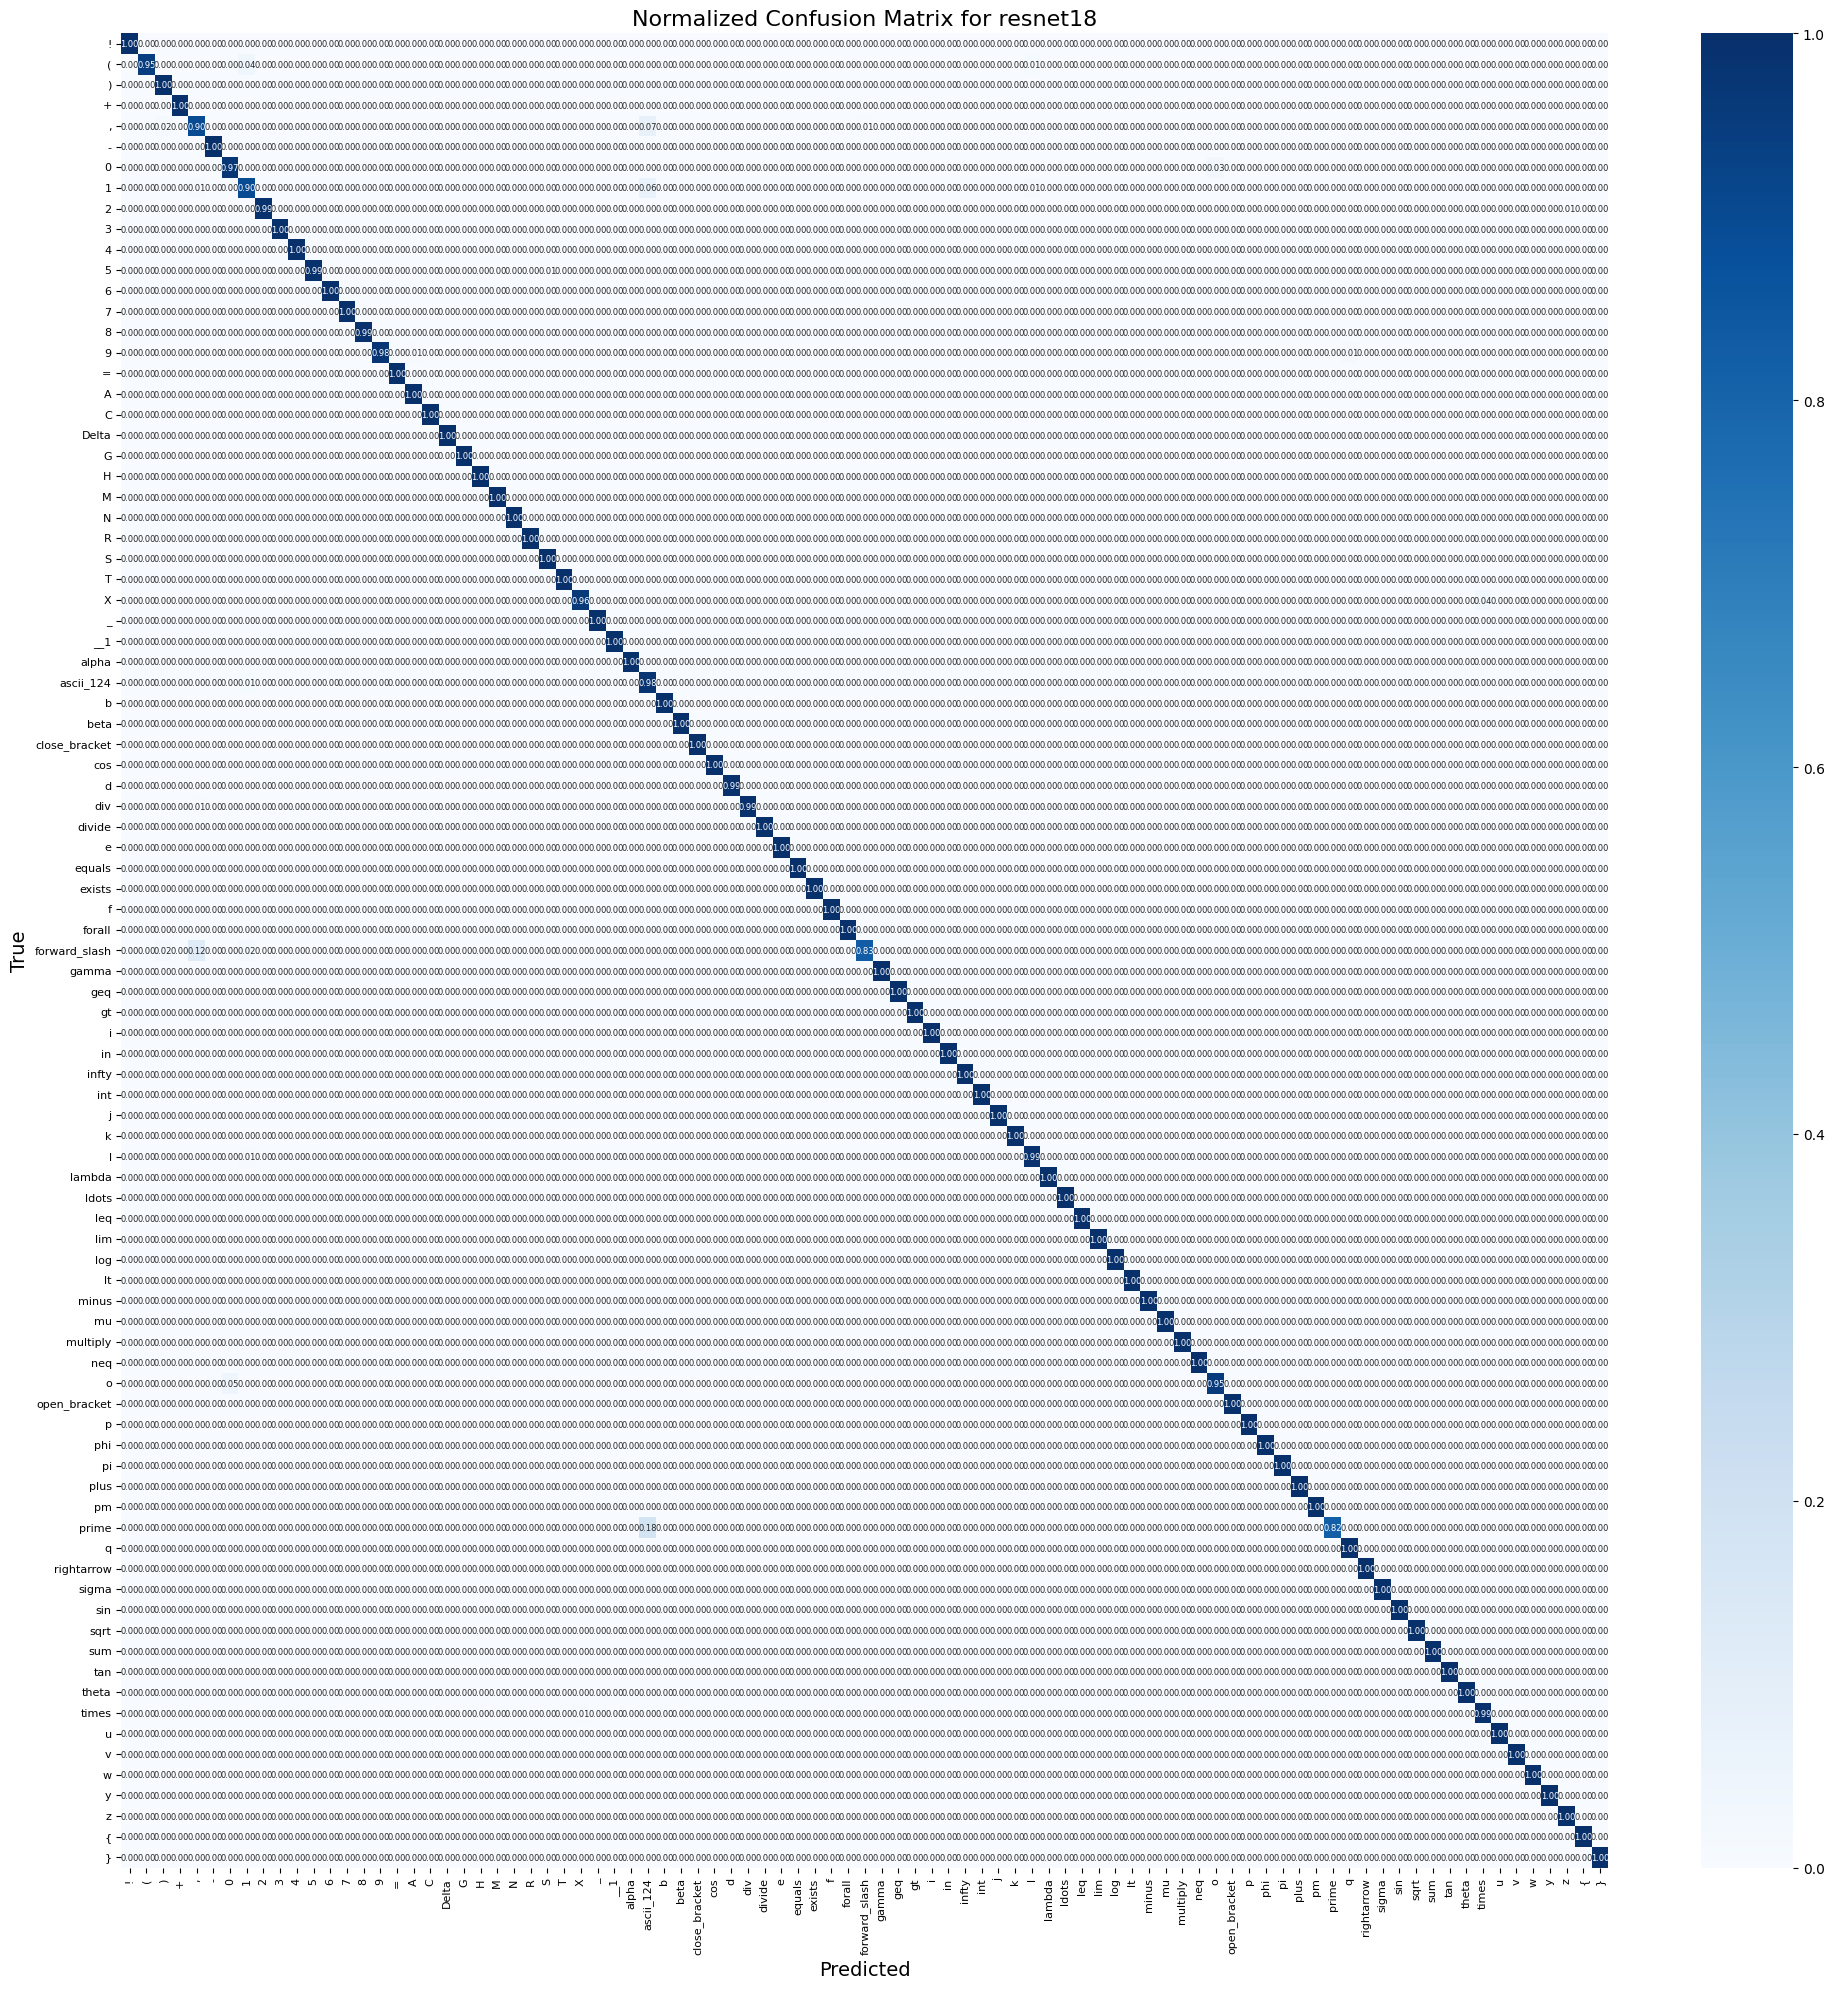


--- Classification Report ---
               precision    recall  f1-score   support

            !       1.00      1.00      1.00       291
            (       0.99      0.95      0.97       299
            )       0.98      1.00      0.99       322
            +       1.00      1.00      1.00       289
            ,       0.95      0.90      0.92       280
            -       1.00      1.00      1.00       299
            0       0.98      0.97      0.98       285
            1       0.93      0.90      0.91       281
            2       1.00      0.99      1.00       318
            3       1.00      1.00      1.00       298
            4       0.99      1.00      1.00       282
            5       1.00      0.99      1.00       306
            6       1.00      1.00      1.00       315
            7       1.00      1.00      1.00       313
            8       1.00      0.99      1.00       297
            9       1.00      0.98      0.99       340
            =       1.00      1.0

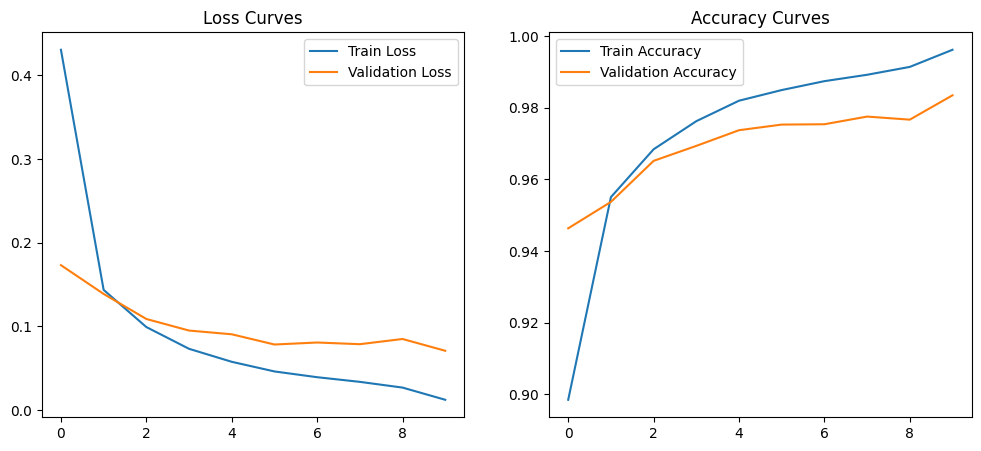

✅ Evaluation complete!


In [1]:
# 05_evaluate.py
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

from models import get_model  # from 03_models.py

# ------------------------
# Config (must match training)
# ------------------------
DATA_DIR = "og_dataset"    # same as training
MODEL_NAME = "resnet18"    # "efficientnet_b0" or "vit_b_16"
BATCH_SIZE = 32
VAL_SPLIT = 0.2
MODEL_PATH = f"{MODEL_NAME}_best.pth"  # saved model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------
# Transforms (same as training val transforms)
# ------------------------
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------
# Dataset + Debug Checks
# ------------------------
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_transforms)

print(f"✅ Classes detected: {full_dataset.classes}")
print(f"✅ Class-to-idx mapping: {full_dataset.class_to_idx}")

targets = [s[1] for s in full_dataset.samples]
print(f"✅ Total samples: {len(full_dataset.samples)}")
print(f"✅ Label range: {min(targets)} → {max(targets)}")

NUM_CLASSES = len(full_dataset.classes)
print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

# sanity check
assert max(targets) < NUM_CLASSES, (
    f"ERROR: Found a label {max(targets)} >= NUM_CLASSES {NUM_CLASSES}. "
    "Likely an empty or corrupted folder exists in dataset!"
)

# ------------------------
# Train/Val split (same seed for reproducibility as training)
# ------------------------
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
_, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
class_names = full_dataset.classes

# ------------------------
# Load Model
# ------------------------
model = get_model(MODEL_NAME, NUM_CLASSES).to(device)  # ✅ FIXED
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ------------------------
# Evaluation
# ------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ------------------------
# Confusion Matrix (Improved)
# ------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues',
    cbar=True,
    annot_kws={"size": 6}
)

plt.title(f'Confusion Matrix for {MODEL_NAME}', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(f'{MODEL_NAME}_confusion_matrix.png', dpi=300, bbox_inches="tight")
plt.show()

# ------------------------
# Normalized Confusion Matrix (percentages)
# ------------------------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_normalized, annot=True, fmt='.2f',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues',
    cbar=True,
    annot_kws={"size": 6}
)

plt.title(f'Normalized Confusion Matrix for {MODEL_NAME}', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(f'{MODEL_NAME}_confusion_matrix_normalized.png', dpi=300, bbox_inches="tight")
plt.show()

# ------------------------
# Classification Report
# ------------------------
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

with open(f'{MODEL_NAME}_report.json', 'w') as f:
    json.dump(report, f)

# ------------------------
# Training Curves (load from history JSON)
# ------------------------
with open(f'{MODEL_NAME}_history.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.savefig(f'{MODEL_NAME}_training_curves.png', dpi=300, bbox_inches="tight")
plt.show()

print("✅ Evaluation complete!")


In [6]:
# 04_train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import json
from tqdm import tqdm
from pathlib import Path

from models import get_model  # from 03_models.py

# ------------------------
# Config
# ------------------------
DATA_DIR = "og_dataset"
MODEL_NAME = "efficientnet_b0"   # "resnet18", "efficientnet_b0", "vit_b_16"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
VAL_SPLIT = 0.2

# Ensure checkpoints folder exists
Path("checkpoints").mkdir(exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------
# Transforms (with Augmentation for Training)
# ------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------
# Dataset + Debug Checks
# ------------------------
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

print(f"✅ Classes detected: {full_dataset.classes}")
print(f"✅ Class-to-idx mapping: {full_dataset.class_to_idx}")

targets = [s[1] for s in full_dataset.samples]
print(f"✅ Total samples: {len(full_dataset.samples)}")
print(f"✅ Label range: {min(targets)} → {max(targets)}")

NUM_CLASSES = len(full_dataset.classes)
print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

assert max(targets) < NUM_CLASSES, (
    f"ERROR: Found a label {max(targets)} >= NUM_CLASSES {NUM_CLASSES}. "
    "Likely an empty or corrupted folder exists in dataset!"
)

# ------------------------
# Train/Val Split
# ------------------------
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Important: validation set should not have augmentation
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ------------------------
# Model, Loss, Optimizer
# ------------------------
model = get_model(MODEL_NAME, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------------------------
# Training Function
# ------------------------
def train_model(model_name, num_epochs=NUM_EPOCHS):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_acc = 0.0
    best_epoch_acc = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= val_size
        val_acc = val_corrects.double() / val_size
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch_acc = epoch + 1
            torch.save(model.state_dict(), f"checkpoints/{model_name}_best.pth")

    # Save history with best epoch info
    history["best_epoch"] = best_epoch_acc
    history["best_val_acc"] = best_val_acc.item()

    with open(f"checkpoints/{model_name}_history.json", "w") as f:
        json.dump(history, f)

    print(f"✅ Training complete! Best Val Acc = {best_val_acc:.4f} at epoch {best_epoch_acc}")

# ------------------------
# Run Training
# ------------------------
if __name__ == "__main__":
    train_model(MODEL_NAME, NUM_EPOCHS)


Using device: cuda
✅ Classes detected: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
✅ Class-to-idx mapping: {'!': 0, '(': 1, ')': 2, '+': 3, ',': 4, '-': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16, 'A': 17, 'C': 18, 'Delta': 19, 'G': 20, 'H': 21, 'M': 22, 'N': 23, 'R': 24, 'S': 25, 'T': 26, 'X': 27, '_': 28, '__1': 29, 'alpha': 30, 'ascii_124': 31, 'b': 32, 'beta': 33, 'close_b

Validation: 100%|██████████| 657/657 [01:11<00:00,  9.24it/s]


Train Loss: 0.7089 Acc: 0.8278
Val   Loss: 0.1803 Acc: 0.9406

Epoch 2/10
--------------------


Validation: 100%|██████████| 657/657 [01:09<00:00,  9.47it/s]


Train Loss: 0.1952 Acc: 0.9382
Val   Loss: 0.1391 Acc: 0.9532

Epoch 3/10
--------------------


Validation: 100%|██████████| 657/657 [00:52<00:00, 12.59it/s]


Train Loss: 0.1439 Acc: 0.9530
Val   Loss: 0.1140 Acc: 0.9644

Epoch 4/10
--------------------


Validation: 100%|██████████| 657/657 [01:02<00:00, 10.46it/s]


Train Loss: 0.1144 Acc: 0.9618
Val   Loss: 0.1040 Acc: 0.9667

Epoch 5/10
--------------------


Validation: 100%|██████████| 657/657 [01:19<00:00,  8.30it/s]


Train Loss: 0.0925 Acc: 0.9689
Val   Loss: 0.0946 Acc: 0.9715

Epoch 6/10
--------------------


Validation: 100%|██████████| 657/657 [01:18<00:00,  8.37it/s]


Train Loss: 0.0787 Acc: 0.9737
Val   Loss: 0.0836 Acc: 0.9754

Epoch 7/10
--------------------


Validation: 100%|██████████| 657/657 [01:34<00:00,  6.95it/s]


Train Loss: 0.0655 Acc: 0.9778
Val   Loss: 0.0840 Acc: 0.9758

Epoch 8/10
--------------------


Validation: 100%|██████████| 657/657 [01:11<00:00,  9.22it/s]


Train Loss: 0.0593 Acc: 0.9805
Val   Loss: 0.0848 Acc: 0.9760

Epoch 9/10
--------------------


Validation: 100%|██████████| 657/657 [00:57<00:00, 11.44it/s]


Train Loss: 0.0508 Acc: 0.9828
Val   Loss: 0.0787 Acc: 0.9783

Epoch 10/10
--------------------


Validation: 100%|██████████| 657/657 [01:18<00:00,  8.33it/s]

Train Loss: 0.0439 Acc: 0.9853
Val   Loss: 0.0751 Acc: 0.9797
✅ Training complete! Best Val Acc = 0.9797 at epoch 10


Using device: cuda
✅ Classes detected: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
✅ Class-to-idx mapping: {'!': 0, '(': 1, ')': 2, '+': 3, ',': 4, '-': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16, 'A': 17, 'C': 18, 'Delta': 19, 'G': 20, 'H': 21, 'M': 22, 'N': 23, 'R': 24, 'S': 25, 'T': 26, 'X': 27, '_': 28, '__1': 29, 'alpha': 30, 'ascii_124': 31, 'b': 32, 'beta': 33, 'close_b

Evaluating: 100%|██████████| 657/657 [03:02<00:00,  3.60it/s]


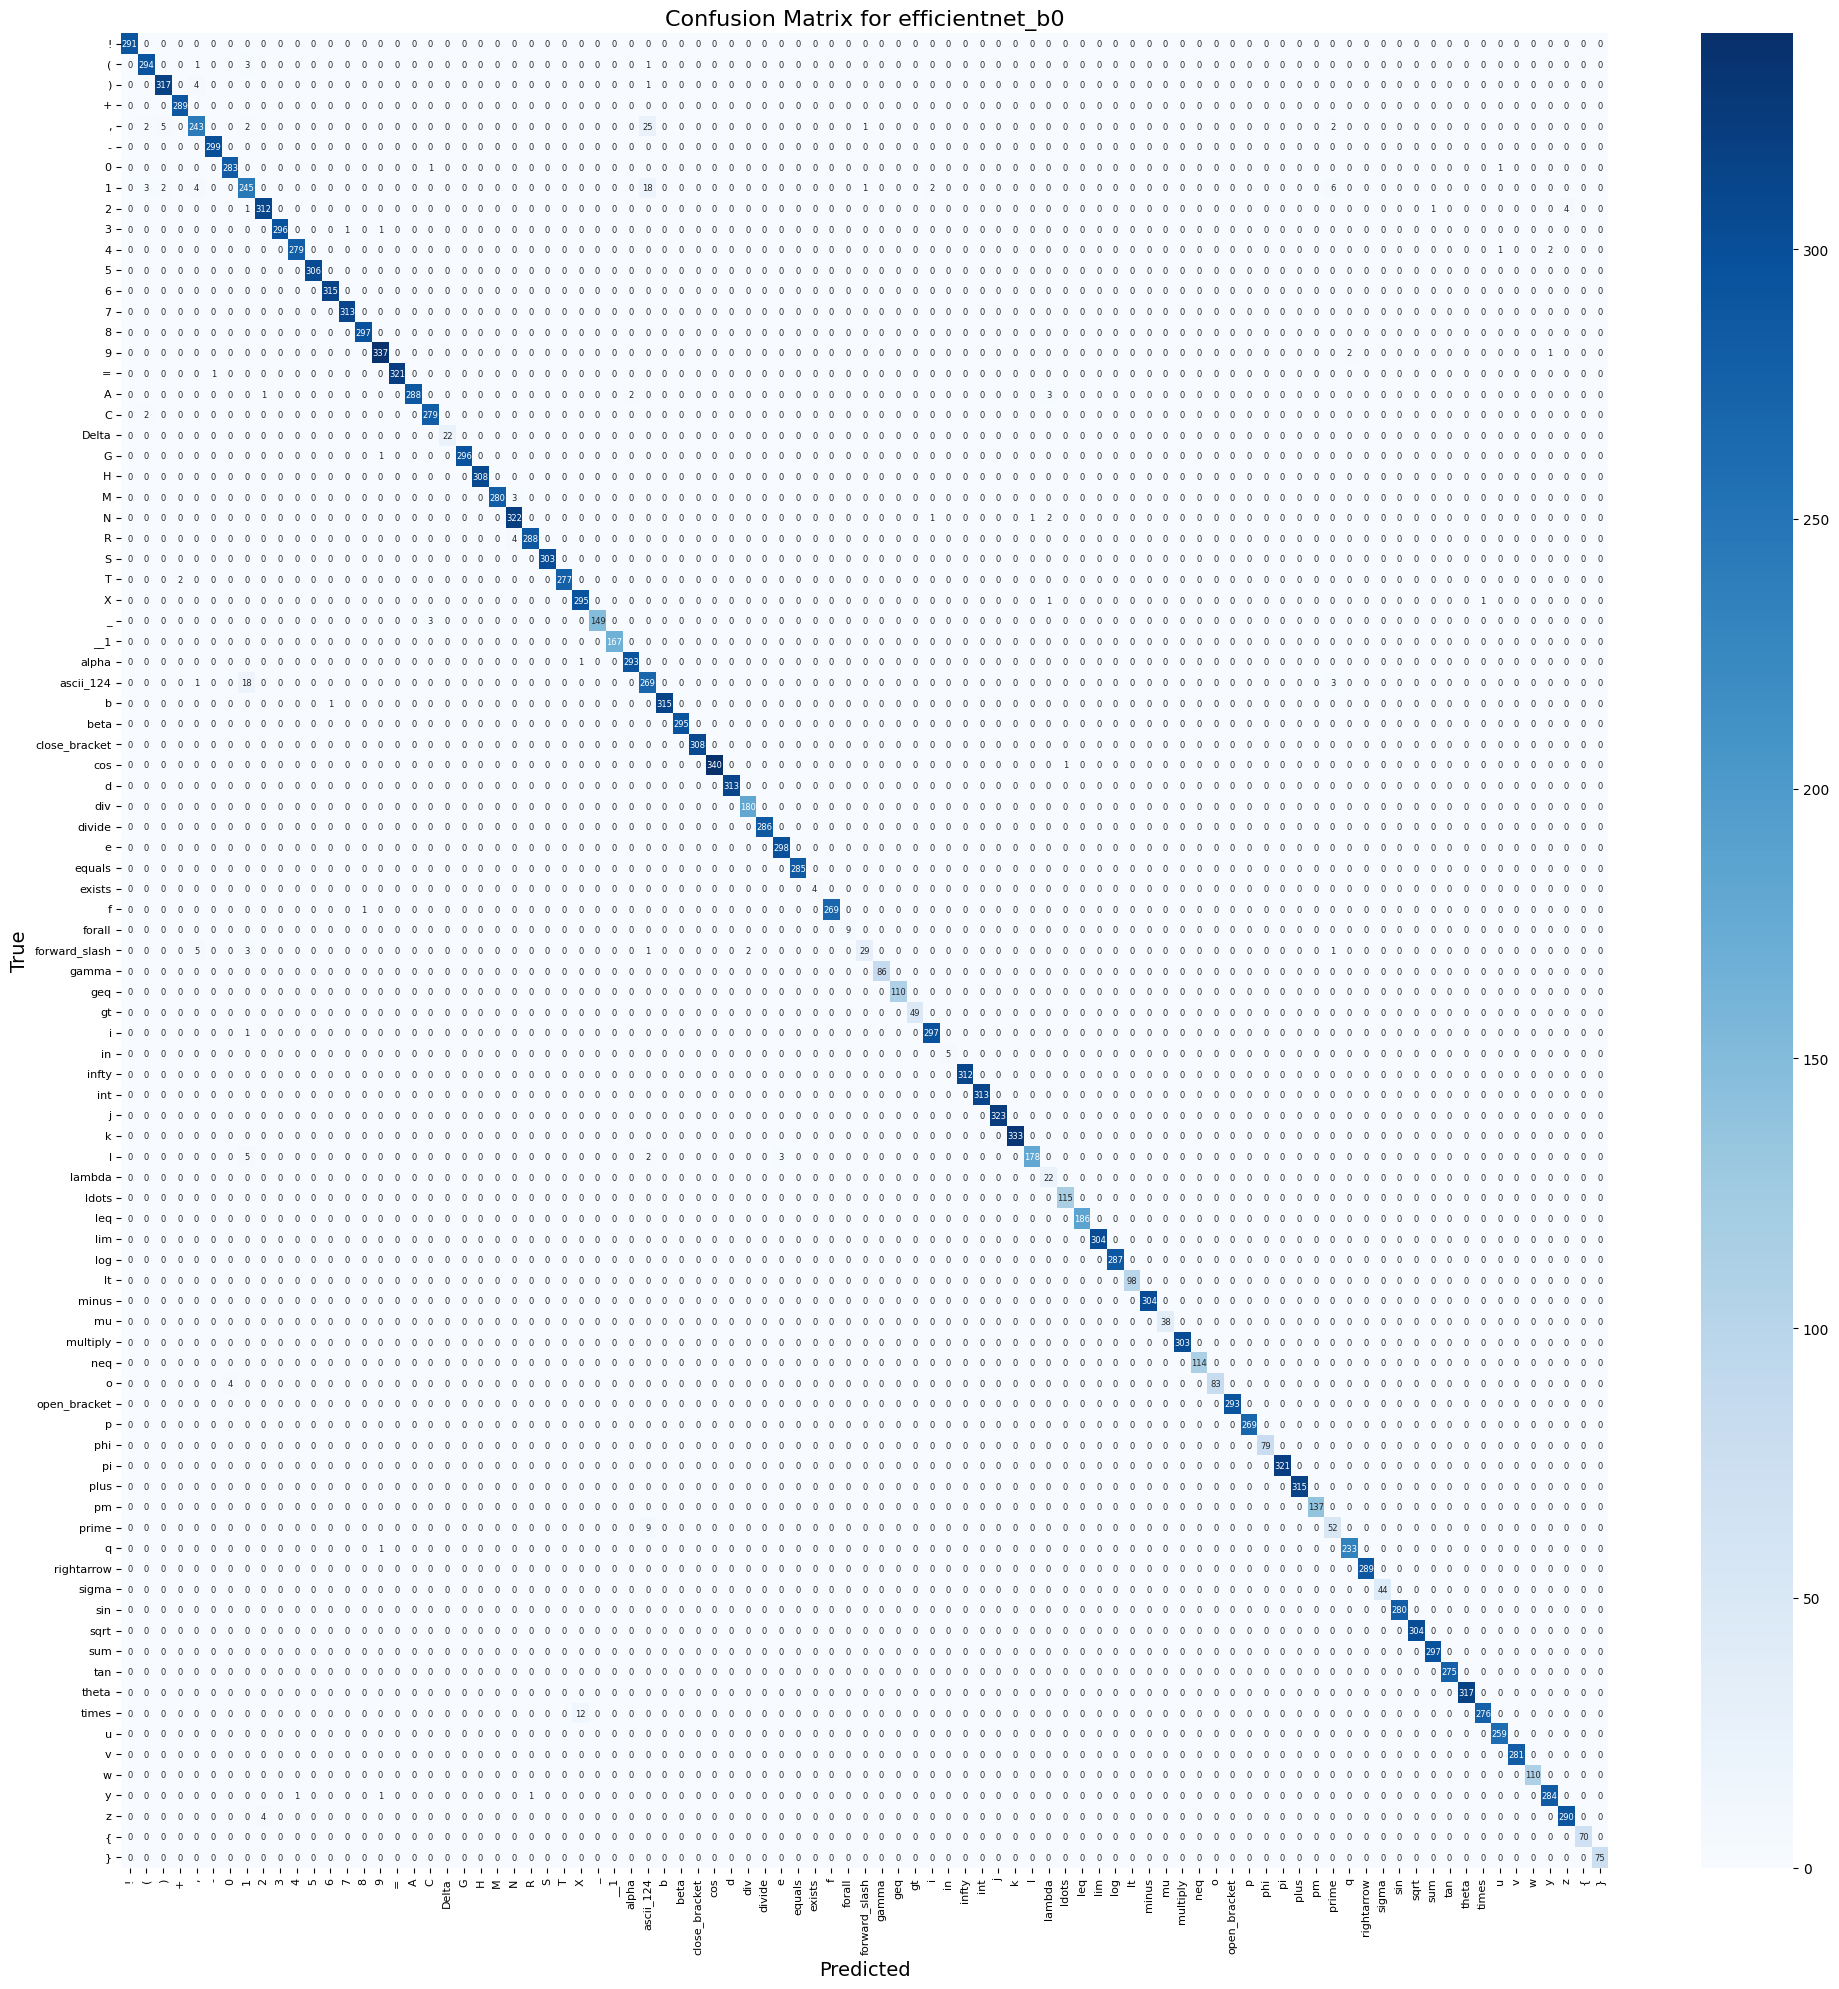

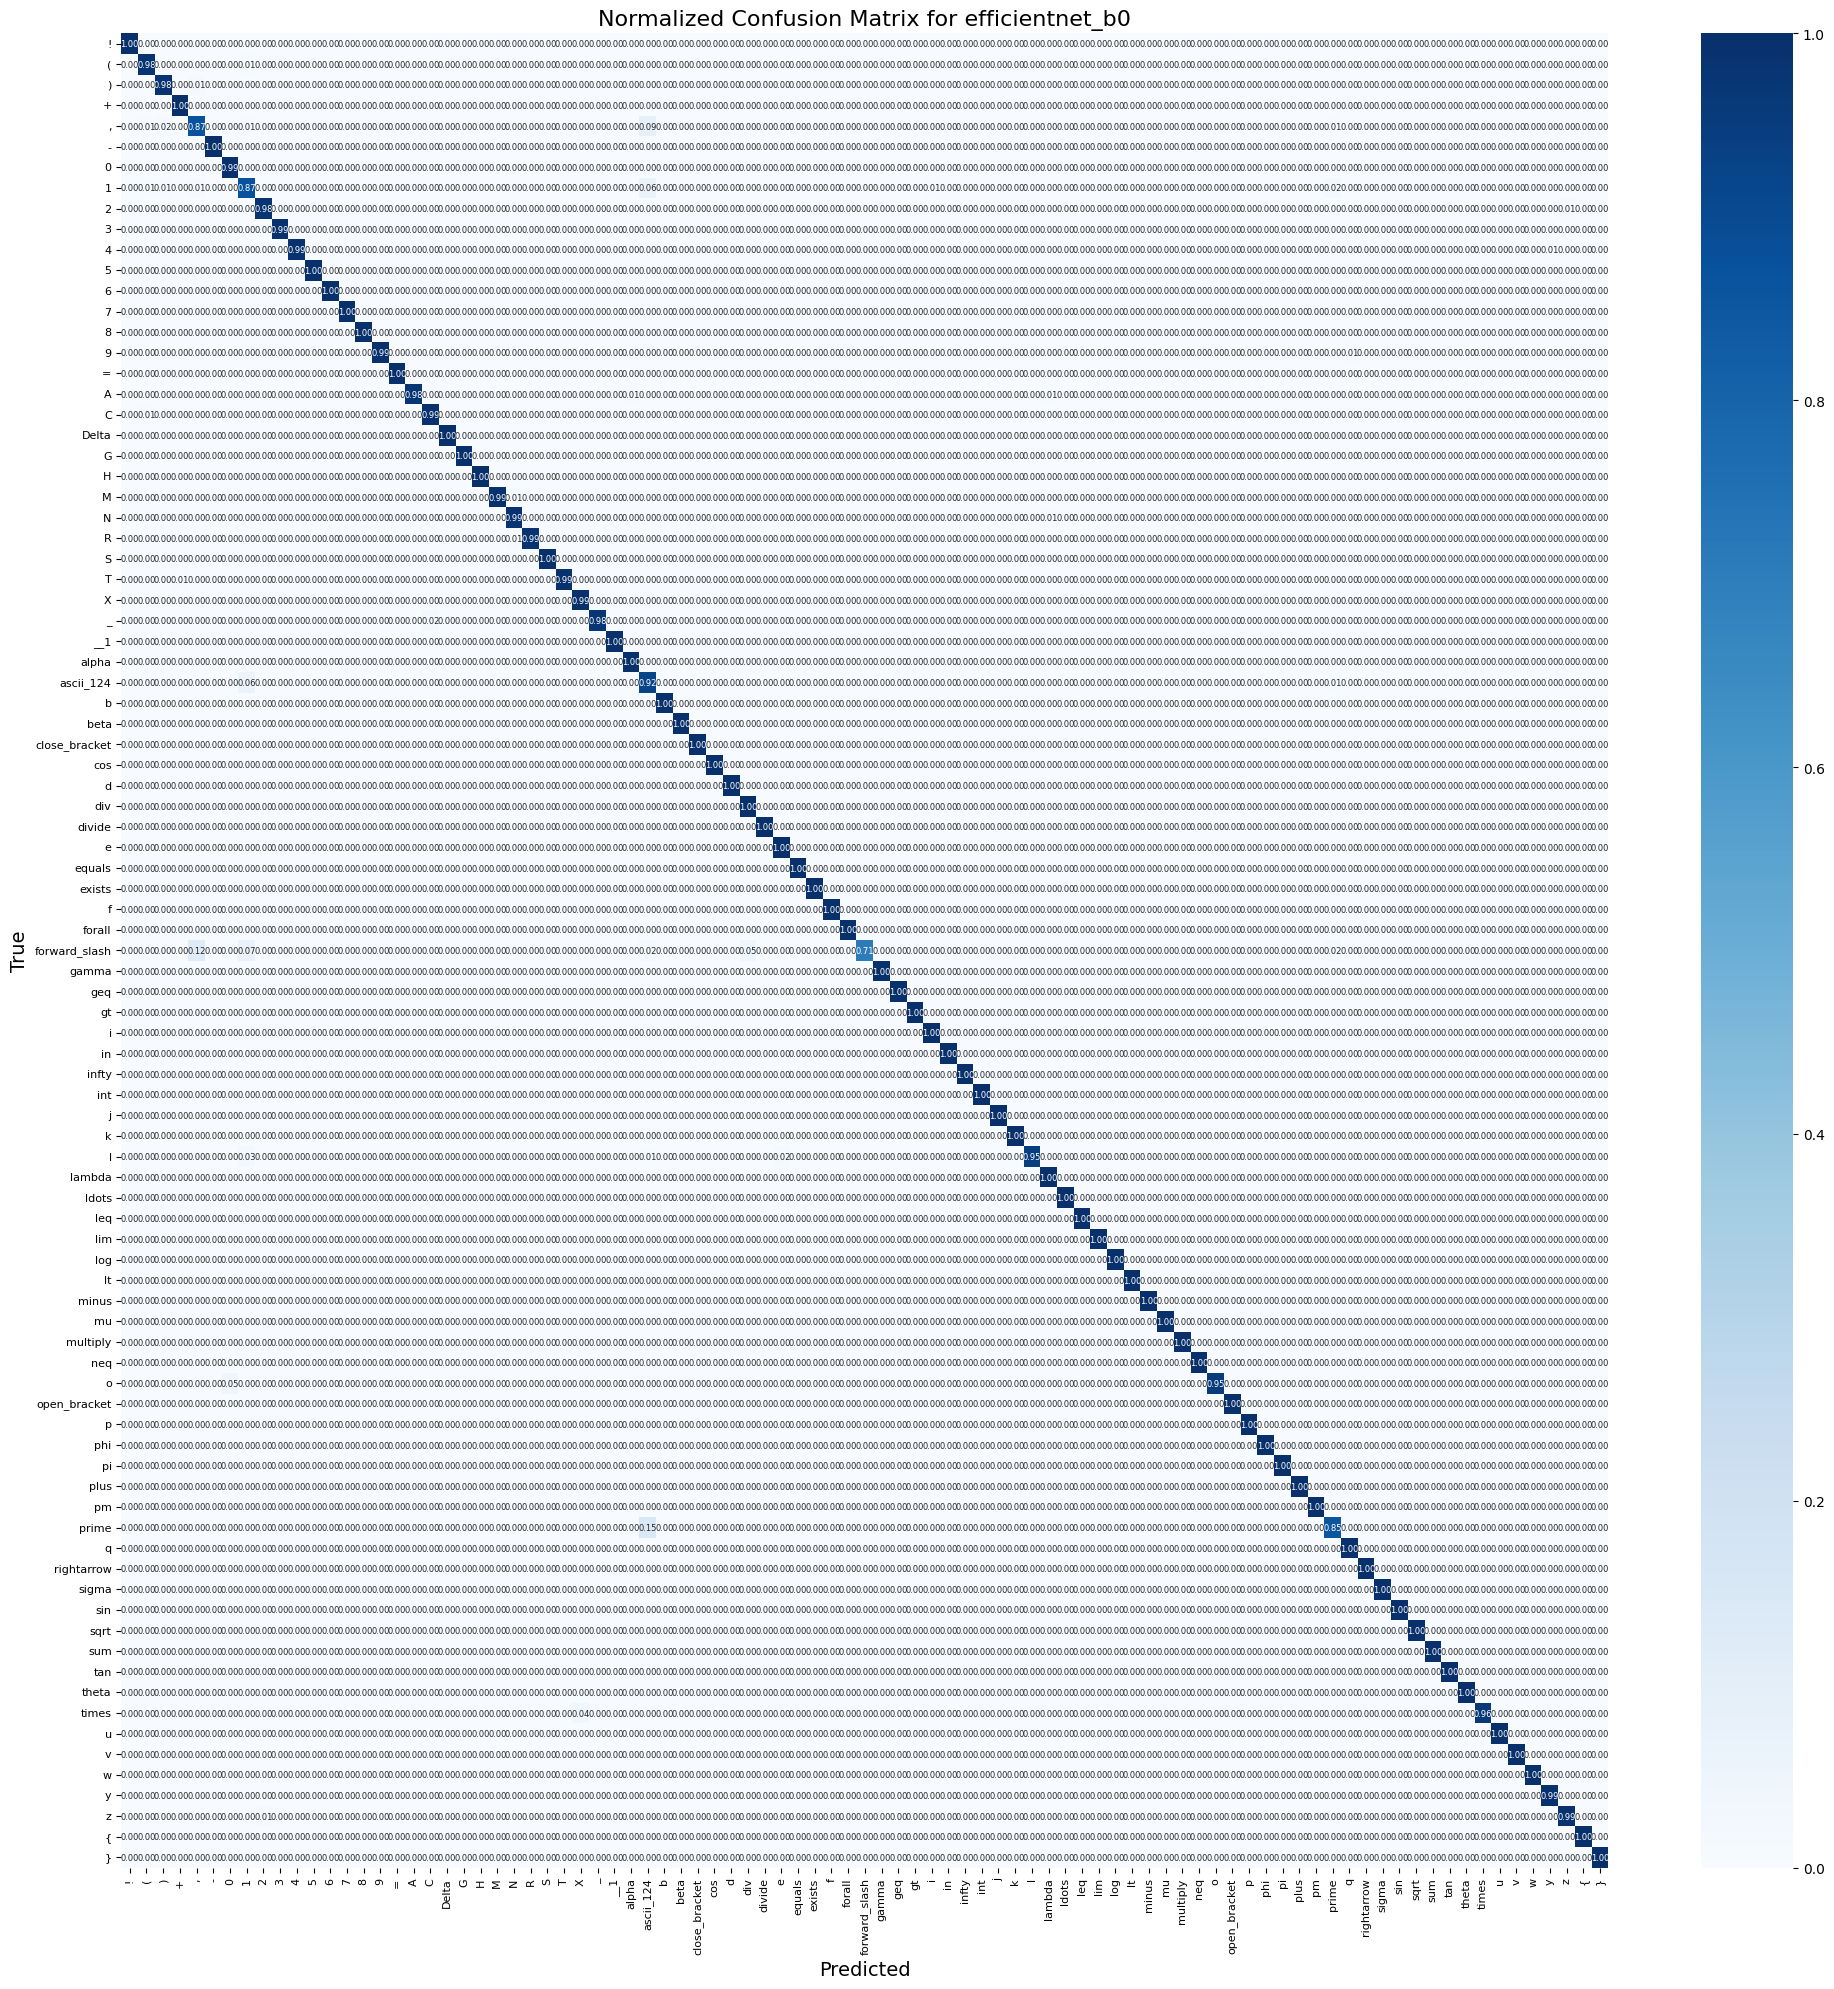


--- Classification Report ---
               precision    recall  f1-score   support

            !       1.00      1.00      1.00       291
            (       0.98      0.98      0.98       299
            )       0.98      0.98      0.98       322
            +       0.99      1.00      1.00       289
            ,       0.94      0.87      0.90       280
            -       1.00      1.00      1.00       299
            0       0.99      0.99      0.99       285
            1       0.88      0.87      0.88       281
            2       0.98      0.98      0.98       318
            3       1.00      0.99      1.00       298
            4       1.00      0.99      0.99       282
            5       1.00      1.00      1.00       306
            6       1.00      1.00      1.00       315
            7       1.00      1.00      1.00       313
            8       1.00      1.00      1.00       297
            9       0.99      0.99      0.99       340
            =       1.00      1.0

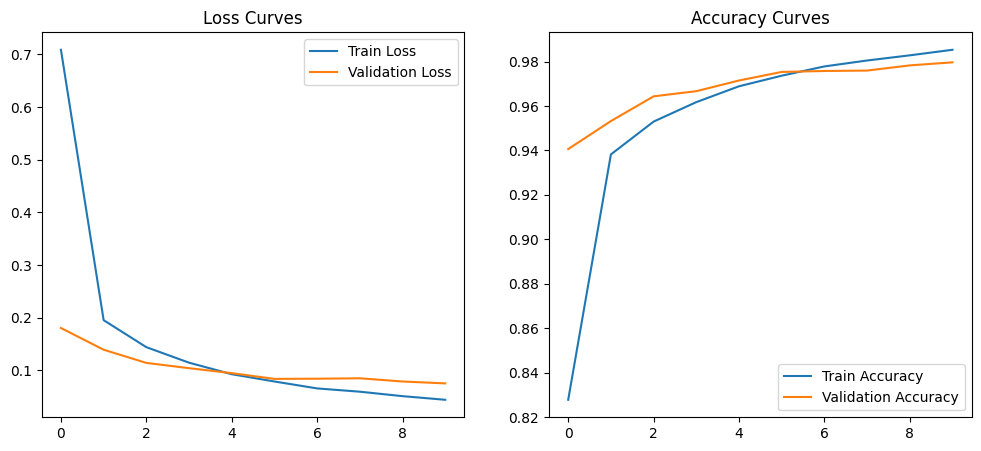

✅ Evaluation complete!


In [1]:
# 05_evaluate.py
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm
from pathlib import Path

from models import get_model  # from 03_models.py

# ------------------------
# Config (match training)
# ------------------------
DATA_DIR = "og_dataset"   # must match training script
MODEL_NAME = "efficientnet_b0"   # updated model
BATCH_SIZE = 32
VAL_SPLIT = 0.2
MODEL_PATH = f"checkpoints/{MODEL_NAME}_best.pth"  # must match training save

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------
# Transforms (same as training)
# ------------------------
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # EfficientNet input size is 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------
# Dataset + Debug Checks
# ------------------------
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_transforms)

print(f"✅ Classes detected: {full_dataset.classes}")
print(f"✅ Class-to-idx mapping: {full_dataset.class_to_idx}")

targets = [s[1] for s in full_dataset.samples]
print(f"✅ Total samples: {len(full_dataset.samples)}")
print(f"✅ Label range: {min(targets)} → {max(targets)}")

NUM_CLASSES = len(full_dataset.classes)
print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

assert max(targets) < NUM_CLASSES, (
    f"ERROR: Found a label {max(targets)} >= NUM_CLASSES {NUM_CLASSES}. "
    "Likely an empty or corrupted folder exists in dataset!"
)

# ------------------------
# Train/Val split (same seed for reproducibility)
# ------------------------
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
_, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
class_names = full_dataset.classes

# ------------------------
# Load Model
# ------------------------
if not Path(MODEL_PATH).exists():
    raise FileNotFoundError(f"❌ Model weights not found at {MODEL_PATH}. Train first!")

model = get_model(MODEL_NAME, NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ------------------------
# Evaluation
# ------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ------------------------
# Confusion Matrix
# ------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues',
    cbar=True,
    annot_kws={"size": 6}
)

plt.title(f'Confusion Matrix for {MODEL_NAME}', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(f'checkpoints/{MODEL_NAME}_confusion_matrix.png', dpi=300, bbox_inches="tight")
plt.show()

# ------------------------
# Normalized Confusion Matrix
# ------------------------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_normalized, annot=True, fmt='.2f',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues',
    cbar=True,
    annot_kws={"size": 6}
)

plt.title(f'Normalized Confusion Matrix for {MODEL_NAME}', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(f'checkpoints/{MODEL_NAME}_confusion_matrix_normalized.png', dpi=300, bbox_inches="tight")
plt.show()

# ------------------------
# Classification Report
# ------------------------
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

with open(f'checkpoints/{MODEL_NAME}_report.json', 'w') as f:
    json.dump(report, f)

# ------------------------
# Training Curves
# ------------------------
history_path = f"checkpoints/{MODEL_NAME}_history.json"
if Path(history_path).exists():
    with open(history_path, 'r') as f:
        history = json.load(f)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.savefig(f'checkpoints/{MODEL_NAME}_training_curves.png', dpi=300, bbox_inches="tight")
    plt.show()

print("✅ Evaluation complete!")


In [ ]:
# 04_train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import json
from tqdm import tqdm
from pathlib import Path

from models import get_model  # from 03_models.py

# ------------------------
# Config
# ------------------------
DATA_DIR = "og_dataset"
MODEL_NAME = "vit_b_16"   # "efficientnet_b0" or "vit_b_16"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
VAL_SPLIT = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------
# Transforms (with augmentation for training)
# ------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------
# Dataset + Debug Checks
# ------------------------
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

print(f"✅ Classes detected: {full_dataset.classes}")
print(f"✅ Class-to-idx mapping: {full_dataset.class_to_idx}")

targets = [s[1] for s in full_dataset.samples]
print(f"✅ Total samples: {len(full_dataset.samples)}")
print(f"✅ Label range: {min(targets)} → {max(targets)}")

NUM_CLASSES = len(full_dataset.classes)
print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

assert max(targets) < NUM_CLASSES, (
    f"ERROR: Found a label {max(targets)} >= NUM_CLASSES {NUM_CLASSES}. "
    "Likely an empty or corrupted folder exists in dataset!"
)

# ------------------------
# Train/Val Split
# ------------------------
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# set correct transform for validation
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ------------------------
# Model, Loss, Optimizer
# ------------------------
model = get_model(MODEL_NAME, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------------------------
# Training Function
# ------------------------
def train_model(model_name, num_epochs=NUM_EPOCHS):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_acc = 0.0
    best_epoch_acc = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= val_size
        val_acc = val_corrects.double() / val_size
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss:a{val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch_acc = epoch + 1
            torch.save(model.state_dict(), f"{model_name}_best.pth")

    # Save history with best epoch info
    history["best_epoch"] = best_epoch_acc
    history["best_val_acc"] = best_val_acc.item()

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history, f)

    print(f"✅ Training complete! Best Val Acc = {best_val_acc:.4f} at epoch {best_epoch_acc}")

# ------------------------
# Run Training
# ------------------------
if __name__ == "__main__":
    train_model(MODEL_NAME, NUM_EPOCHS)


Using device: cuda
✅ Classes detected: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
✅ Class-to-idx mapping: {'!': 0, '(': 1, ')': 2, '+': 3, ',': 4, '-': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16, 'A': 17, 'C': 18, 'Delta': 19, 'G': 20, 'H': 21, 'M': 22, 'N': 23, 'R': 24, 'S': 25, 'T': 26, 'X': 27, '_': 28, '__1': 29, 'alpha': 30, 'ascii_124': 31, 'b': 32, 'beta': 33, 'close_b

Validation: 100%|██████████| 657/657 [05:36<00:00,  1.95it/s]


Train Loss: 0.4382 Acc: 0.8791
Val   Loss: 0.2043 Acc: 0.9343

Epoch 2/10
--------------------


Validation: 100%|██████████| 657/657 [03:17<00:00,  3.32it/s]


Train Loss: 0.2075 Acc: 0.9327
Val   Loss: 0.1892 Acc: 0.9378

Epoch 3/10
--------------------


Validation: 100%|██████████| 657/657 [03:08<00:00,  3.49it/s]


Train Loss: 0.1664 Acc: 0.9449
Val   Loss: 0.1859 Acc: 0.9389

Epoch 4/10
--------------------


Validation: 100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Train Loss: 0.1358 Acc: 0.9538
Val   Loss: 0.1457 Acc: 0.9519

Epoch 5/10
--------------------


Validation: 100%|██████████| 657/657 [03:21<00:00,  3.26it/s]


Train Loss: 0.1146 Acc: 0.9603
Val   Loss: 0.1208 Acc: 0.9597

Epoch 6/10
--------------------


Validation: 100%|██████████| 657/657 [03:14<00:00,  3.38it/s]


Train Loss: 0.1046 Acc: 0.9645
Val   Loss: 0.1215 Acc: 0.9601

Epoch 7/10
--------------------


Validation: 100%|██████████| 657/657 [03:21<00:00,  3.26it/s]


Train Loss: 0.0881 Acc: 0.9696
Val   Loss: 0.1037 Acc: 0.9662

Epoch 8/10
--------------------


Validation: 100%|██████████| 657/657 [05:19<00:00,  2.05it/s]


Train Loss: 0.0819 Acc: 0.9721
Val   Loss: 0.1102 Acc: 0.9637

Epoch 9/10
--------------------


Validation: 100%|██████████| 657/657 [03:07<00:00,  3.51it/s]


Train Loss: 0.0673 Acc: 0.9766
Val   Loss: 0.0971 Acc: 0.9700

Epoch 10/10
--------------------


Validation: 100%|██████████| 657/657 [03:18<00:00,  3.31it/s]

Train Loss: 0.0622 Acc: 0.9787
Val   Loss: 0.1005 Acc: 0.9686
✅ Training complete! Best Val Acc = 0.9700 at epoch 9


In [1]:
# 05_evaluate.py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models import get_model  # from 03_models.py

# ------------------------
# Config (same as training)
# ------------------------
DATA_DIR = "og_dataset"
MODEL_NAME = "vit_b_16"   # same model you trained in 04_train.py
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------
# Transforms (evaluation only, no augmentation)
# ------------------------
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------
# Dataset & Loader
# ------------------------
dataset = datasets.ImageFolder(root=DATA_DIR, transform=eval_transforms)
NUM_CLASSES = len(dataset.classes)
print(f"✅ Classes: {dataset.classes}")

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ------------------------
# Load Model
# ------------------------
model = get_model(MODEL_NAME, NUM_CLASSES).to(device)
model.load_state_dict(torch.load(f"{MODEL_NAME}_best.pth", map_location=device))
model.eval()

criterion = nn.CrossEntropyLoss()

# ------------------------
# Evaluation
# ------------------------
all_preds, all_labels = [], []
total_loss, total_correct = 0.0, 0

with torch.no_grad():
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_loss = total_loss / len(dataset)
avg_acc = total_correct.double().item() / len(dataset)

print(f"\n📊 Evaluation Results")
print(f"Loss: {avg_loss:.4f}")
print(f"Accuracy: {avg_acc:.4f}")

# ------------------------
# Classification Report & Confusion Matrix
# ------------------------
report = classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4)
cm = confusion_matrix(all_labels, all_preds)

print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)

# ------------------------
# Plot Confusion Matrix
# ------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{MODEL_NAME}_confusion_matrix.png")
plt.close()
print(f"✅ Saved confusion matrix to {MODEL_NAME}_confusion_matrix.png")

# ------------------------
# Save metrics
# ------------------------
results = {
    "loss": avg_loss,
    "accuracy": avg_acc,
    "classification_report": report,
    "confusion_matrix": cm.tolist()
}

with open(f"{MODEL_NAME}_eval.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"✅ Saved evaluation results to {MODEL_NAME}_eval.json")


Using device: cuda
✅ Classes: ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '_', '__1', 'alpha', 'ascii_124', 'b', 'beta', 'close_bracket', 'cos', 'd', 'div', 'divide', 'e', 'equals', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'minus', 'mu', 'multiply', 'neq', 'o', 'open_bracket', 'p', 'phi', 'pi', 'plus', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']

📊 Evaluation Results
Loss: 0.0580
Accuracy: 0.9805

Classification Report:
                precision    recall  f1-score   support

            !     1.0000    1.0000    1.0000      1300
            (     0.9419    0.9827    0.9618      1500
            )     0.9643    0.9367    0.9503      1500
            +     0.9432    0.9967    0.9692      1500
      